#### 📂 Practical Lab 1

#### Streaming Data for Predictive Maintenance with Linear Regression-Based Alerts

In the data_stream_visualization workshop, the robot current data were ingested from the given CSV file and the records were inserted into the database. 

In this workshop, all the records will be retreived from the database and be used for Predictive Maintenance with Linear Regression-Based Alerts

## Step number 1: Define the problem/task: 

In this workshop, we are going to train a moden using univariate linear regression. The data being used to train the model is the given current data generated by a robot with 8 active axis.

Then we are going to produce testing data synthetically to validate the model behaviour and to run predictions. 

The model will then generate plots to visualize the regression. Alert and Errors will be marked on the plots using annotation. 

The model will also store Alert and Error events in a structured CSV or database table for documentaion for future references.

#### Objective:
Build predictive models for each of the robot’s 8 active axes to understand and forecast how current (kWh) evolves over time.

#### Approach:

For each axis (#1–#8), train a univariate linear regression where:

 - Input (X): Time (in seconds, relative to the first recorded timestamp).

 - Output (y): Current drawn by that axis.

Use the model to predict expected current values given new time data.

#### Motivation:

Currents can drift from normal behavior due to wear, overload, or anomalies.

By defining a baseline regression line, deviations (residuals) can be detected and analyzed.

This baseline becomes the foundation for monitoring, alerts, and error detection.

#### Scope:

Eight independent models (one per axis).

Each model is simple (linear), prioritizing interpretability and ease of residual analysis.

Focus is on time-based forecasting and anomaly detection, not multi-variable prediction.

## Install dependencies

In [120]:
# Uncomment the line below to install dependencies
# %pip install -r requirements.txt

In [121]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
from dotenv import load_dotenv

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Load the .env file
load_dotenv()

import importlib

import DataExtraction.DBManager as DBManager
importlib.reload(DBManager)

import DataExtraction.FileManager as FileManager
importlib.reload(FileManager)

import DataPreparation.DataPrepairer as DataPrepairer
importlib.reload(DataPrepairer)

import ModelTraining.ModelTrainer as ModelTrainer
importlib.reload(ModelTrainer)

import DataAnalysis.DataAnalyzer as DataAnalyzer
importlib.reload(DataAnalyzer)


<module 'DataAnalysis.DataAnalyzer' from 'c:\\Users\\MOSTAFA\\Desktop\\Foundations of ML Frameworks\\Practical Lab 1\\Predictive-Maintenance-with-Linear-Regression\\DataAnalysis\\DataAnalyzer.py'>

## Step 2: Data Preparation

In [122]:
# Initialize FileManager with the path to the training CSV file
training_data_csv_path = "../data/raw/RMBR4-2_export_test.csv"
fileManager = FileManager.FileManager(training_data_csv_path)

# Load the dataset
df_train = fileManager.get_data()

# Drop unused columns. Keep only 'time' and Axis #1 to Axis #8 columns
axis_columns = [f'Axis #{i}' for i in range(1, 9)]
columns_to_keep = ['time'] + axis_columns
df_train = df_train[columns_to_keep]

# Initialize DataPrepairer
dataPrepairer = DataPrepairer.DataPrepairer(df_train)

# Handle missing values 
dataPrepairer.handle_missing_values(method='interpolate')

# Resolve duplicate timestamps if any 
dataPrepairer.handle_duplicates(['time'])

# Parse timestamp
dataPrepairer.parse_timestamps('time')

# Sort chronologically - Might not be necessary
dataPrepairer.sort_chronologically('time')

# Record min and max timestamps for diagnostics
time_min = df_train['time'].min()
time_max = df_train['time'].max()

# Create numeric time in seconds since first timestamp
df_train['time_numeric'] = (df_train['time'] - time_min).dt.total_seconds()

# print(" time vs. time_numeric report:")
# df_train[['time', 'time_numeric']].head()
# df_train[['time', 'time_numeric']].tail()



✅ Successfully loaded 39672 rows from ../data/raw/RMBR4-2_export_test.csv
 Missing values per column report: {'time': 0, 'Axis #1': 0, 'Axis #2': 0, 'Axis #3': 0, 'Axis #4': 0, 'Axis #5': 0, 'Axis #6': 0, 'Axis #7': 0, 'Axis #8': 0}
✅ No missing values detected. Moving on...
✅ No duplicate rows detected based on columns ['time']. Moving on...
✅ Successfully parsed 'time' to timezone-aware datetime (UTC).
✅ Successfully sorted data chronologically by 'time'.


c:\Users\MOSTAFA\Desktop\Foundations of ML Frameworks\Practical Lab 1\Predictive-Maintenance-with-Linear-Regression\DataPreparation\DataPrepairer.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[time_col] = pd.to_datetime(self.data[time_col], utc=True, errors='coerce')
C:\Users\MOSTAFA\AppData\Local\Temp\ipykernel_17852\4078969404.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['time_numeric'] = (df_train['time'] - time_min).dt.total_seconds()


## Step 3: Outlier detection & handling

In [123]:
# Outlier detection & handling
outlier_report = {}

# Copy for safe handling
df_clean = df_train.copy()

for axis in axis_columns:

    # Pass only the axis Series to DataAnalyzer
    dataAnalyzer = DataAnalyzer.DataAnalyzer(df_train[axis])    

    # Store report
    outlier_report[axis] = dataAnalyzer.Outlier_Report

    # Print outlier report for the axis
    print(f"\n✅ {axis}:")
    dataAnalyzer.print_outlier_report()

    # Handle outliers (here: clip to bounds)
    df_clean.loc[dataAnalyzer.Mask_outliers, axis] = np.clip(
        df_train[axis], dataAnalyzer.Lowerbound, dataAnalyzer.Upperbound
    )

# df_clean.head()



✅ Axis #1:
    Q1: 0.0
    Q3: 0.31271
    IQR: 0.31271
    Bounds: [-0.47, 0.78]
    Number of Outliers detected: 6420
    Outlier Indices: [31, 33, 34, 38, 39, 41, 77, 79, 81, 82]

✅ Axis #2:
    Q1: 0.0
    Q3: 4.21719
    IQR: 4.21719
    Bounds: [-6.33, 10.54]
    Number of Outliers detected: 6952
    Outlier Indices: [31, 32, 33, 35, 37, 80, 83, 84, 85, 87]

✅ Axis #3:
    Q1: 0.0
    Q3: 4.58619
    IQR: 4.58619
    Bounds: [-6.88, 11.47]
    Number of Outliers detected: 2311
    Outlier Indices: [31, 40, 41, 43, 77, 82, 84, 86, 88, 89]

✅ Axis #4:
    Q1: 0.0
    Q3: 0.51619
    IQR: 0.51619
    Bounds: [-0.77, 1.29]
    Number of Outliers detected: 5619
    Outlier Indices: [31, 32, 33, 38, 39, 40, 43, 77, 78, 81]

✅ Axis #5:
    Q1: 0.0
    Q3: 0.80009
    IQR: 0.80009
    Bounds: [-1.20, 2.00]
    Number of Outliers detected: 6144
    Outlier Indices: [31, 32, 33, 39, 77, 78, 79, 80, 81, 101]

✅ Axis #6:
    Q1: 0.0
    Q3: 0.36133
    IQR: 0.36133
    Bounds: [-0.54, 0.90]

In [124]:
# Not our approach for this lab - Moving on

# --- Split data into training and testing sets --- 
# from sklearn.model_selection import train_test_split
# Define train/test split ratio (e.g., 80% train, 20% test)
# train_size = 0.8

# # Compute split index
# split_index = int(len(df_train) * train_size)

# # Training set: first 80% of time
# df_train = df_train.iloc[:split_index].reset_index(drop=True)

# # Testing set: last 20% of time
# df_test = df_train.iloc[split_index:].reset_index(drop=True)

# print("Training set shape:", df_train.shape)
# print("Testing set shape:", df_test.shape)
# print("Training time range:", time_min, "to", time_max)
# print("Testing time range:", df_test['time'].min(), "to", df_test['time'].max())


## Step 4: Train Linear Regression Models (One per Axis)

We will:
1. Convert the timestamp into a numeric variable (`time_numeric`).
2. For each axis (#1–#8):
   - Fit a linear regression model: **time → axis current**
   - Record the slope (coefficient) and intercept.
   - Store the model for later predictions.

Explanation:
- **Slope (coefficient):** tells us how fast the current changes with time.
  - Positive slope → current is trending upward.
  - Negative slope → current is trending downward.
- **Intercept:** the estimated starting current at time = 0.
- We now have 8 independent regression models, one per axis.

In [125]:
# Dictionary to store trained models and coefficients
models = {}
coefficients = {}

# Train a linear regression model for each axis
for axis in axis_columns:
    # Reshape input for sklearn
    x_train = df_train[['time_numeric']]
    y_train = df_train[axis]

    # Initialize and fit linear regression
    modelTrainer = ModelTrainer.ModelTrainer(x_train, y_train)
    model = modelTrainer.train_model(method='linear_regression')
    # Store model and coefficients
    models[axis] = model
    coefficients[axis] = {
        "slope": model.coef_[0],
        "intercept": model.intercept_
    }

# Display slope and intercept for each axis
for axis, coef in coefficients.items():
    print(f"\n ✅{axis}: slope = {coef['slope']:.6f}, intercept = {coef['intercept']:.6f}")


 ✅Axis #1: slope = -0.000000, intercept = 0.730542

 ✅Axis #2: slope = 0.000002, intercept = 3.523886

 ✅Axis #3: slope = -0.000001, intercept = 2.733898

 ✅Axis #4: slope = 0.000000, intercept = 0.604357

 ✅Axis #5: slope = 0.000000, intercept = 0.951103

 ✅Axis #6: slope = 0.000000, intercept = 0.580077

 ✅Axis #7: slope = 0.000001, intercept = 0.847563

 ✅Axis #8: slope = 0.000000, intercept = 0.098748


## Step 5: Generating testing data synthetically

In [126]:
# Generate synthetic timeline using actual time values from df
synthetic_times = pd.date_range(
    start = time_min, 
    end = time_max, 
    periods = 200
)
synthetic_data = pd.DataFrame({"time": synthetic_times})

# Convert time to numeric (seconds since start)
synthetic_data["time_numeric"] = (synthetic_data["time"] - time_min).dt.total_seconds()

# Generate axis values based on model + noise
for axis in axis_columns:
    y_pred = models[axis].predict(synthetic_data[['time_numeric']])
    noise = np.random.normal(0, 0.5, len(y_pred))  # small Gaussian noise
    synthetic_data[axis] = y_pred + noise

    # Inject anomalies for testing Alerts/Errors
    if axis == "Axis #1":
        synthetic_data.loc[30:40, axis] += 5   # Alert deviation
    if axis == "Axis #2":
        synthetic_data.loc[100:110, axis] += 10  # Error deviation

fileManager.write_csv("../data/processed/synthetic_test_data.csv", synthetic_data)

df_test = synthetic_data

df_test.head()

✅ Successfully wrote data to ../data/processed/synthetic_test_data.csv


,time,time_numeric,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
0,2022-10-17 12:18:23.660000+00:00,0.000000,0.526496,3.174003,1.850826,0.514327,1.122091,0.352274,1.190341,-0.558826
1,2022-10-17 12:25:09.664864321+00:00,406.004864,0.936622,3.273523,2.439345,1.116364,1.025479,0.048529,0.129595,-0.092983
2,2022-10-17 12:31:55.669728643+00:00,812.009729,0.512960,2.983431,3.117522,0.154248,0.881493,0.883389,0.897041,-0.267946
3,2022-10-17 12:38:41.674592964+00:00,1218.014593,0.833925,4.246289,2.499016,1.277466,0.388672,0.637324,1.669272,-0.372830
4,2022-10-17 12:45:27.679457286+00:00,1624.019457,1.020401,2.905013,2.763066,1.632672,1.259672,1.017234,0.023297,0.136952


## Step 6: Prediction.

We will:
1. Use the trained regression models for each axis.
2. Predict the expected current values on the test set (`df_test`).
3. Store predictions alongside the actual values for analysis.

In [127]:
# Copy test set to hold predictions
df_pred = df_test.copy()

# For each axis, generate predictions
for axis, model in models.items():
    df_pred[f'{axis}_pred'] = model.predict(df_test[['time_numeric']])

df_pred.head(10)

,time,time_numeric,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8,Axis #1_pred,Axis #2_pred,Axis #3_pred,Axis #4_pred,Axis #5_pred,Axis #6_pred,Axis #7_pred,Axis #8_pred
0,2022-10-17 12:18:23.660000+00:00,0.000000,0.526496,3.174003,1.850826,0.514327,1.122091,0.352274,1.190341,-0.558826,0.730542,3.523886,2.733898,0.604357,0.951103,0.580077,0.847563,0.098748
1,2022-10-17 12:25:09.664864321+00:00,406.004864,0.936622,3.273523,2.439345,1.116364,1.025479,0.048529,0.129595,-0.092983,0.730494,3.524777,2.733663,0.604515,0.951137,0.580270,0.847787,0.098782
2,2022-10-17 12:31:55.669728643+00:00,812.009729,0.512960,2.983431,3.117522,0.154248,0.881493,0.883389,0.897041,-0.267946,0.730447,3.525668,2.733429,0.604673,0.951171,0.580463,0.848012,0.098817
3,2022-10-17 12:38:41.674592964+00:00,1218.014593,0.833925,4.246289,2.499016,1.277466,0.388672,0.637324,1.669272,-0.372830,0.730399,3.526558,2.733194,0.604831,0.951205,0.580655,0.848237,0.098851
4,2022-10-17 12:45:27.679457286+00:00,1624.019457,1.020401,2.905013,2.763066,1.632672,1.259672,1.017234,0.023297,0.136952,0.730351,3.527449,2.732960,0.604989,0.951239,0.580848,0.848462,0.098886
5,2022-10-17 12:52:13.684321608+00:00,2030.024322,0.169414,3.944504,2.528441,0.792705,1.728557,0.108293,0.761661,-0.330345,0.730303,3.528340,2.732725,0.605146,0.951273,0.581040,0.848687,0.098920
6,2022-10-17 12:58:59.689185929+00:00,2436.029186,-0.053416,4.082330,3.468299,0.589930,1.224613,0.723748,0.935009,0.056483,0.730255,3.529231,2.732491,0.605304,0.951307,0.581233,0.848912,0.098955
7,2022-10-17 13:05:45.694050251+00:00,2842.034050,0.920587,3.036846,3.133930,1.451140,0.530721,0.893674,0.635589,0.496619,0.730208,3.530122,2.732256,0.605462,0.951341,0.581426,0.849136,0.098989
8,2022-10-17 13:12:31.698914572+00:00,3248.038915,0.927910,3.795155,3.177243,0.589375,0.649152,1.190347,0.909443,-0.319856,0.730160,3.531013,2.732021,0.605620,0.951375,0.581618,0.849361,0.099024
9,2022-10-17 13:19:17.703778894+00:00,3654.043779,1.193533,3.522379,2.627708,0.973712,1.802599,1.429895,2.099469,-0.958440,0.730112,3.531904,2.731787,0.605778,0.951409,0.581811,0.849586,0.099058


## Step 7: Visualize Actual vs Predicted with Regression Lines

We will:
1. Plot the actual scatter data for each axis (time vs. current).
2. Overlay the regression line (predicted values).
3. This helps us visually check how well the linear model fits the data.

✅ Successfully saved plot to ../reports/obs_vs_pred_plots/Axis_#1_obs_vs_pred.png


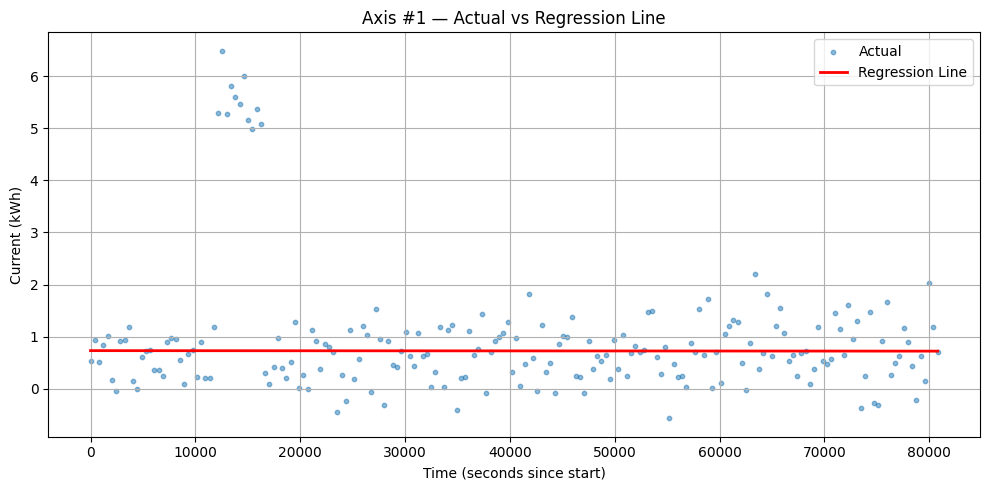

✅ Successfully saved plot to ../reports/obs_vs_pred_plots/Axis_#2_obs_vs_pred.png


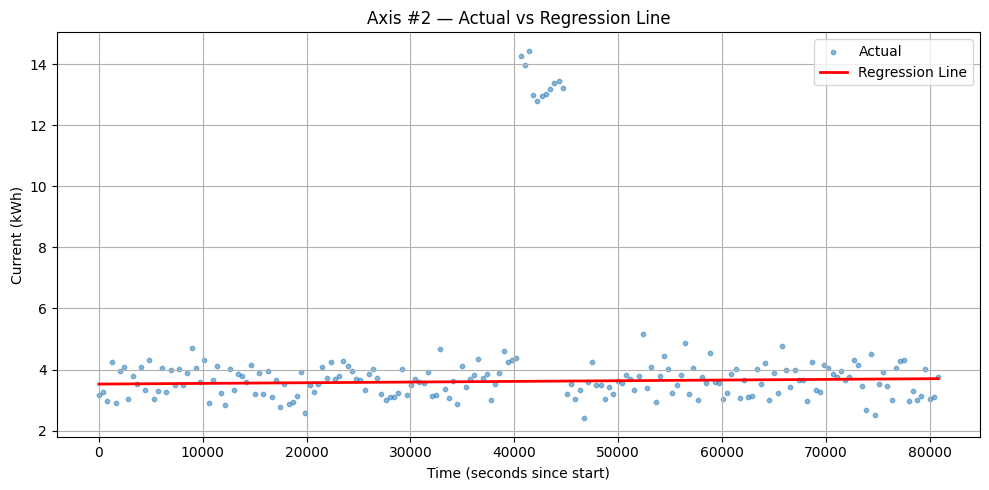

✅ Successfully saved plot to ../reports/obs_vs_pred_plots/Axis_#3_obs_vs_pred.png


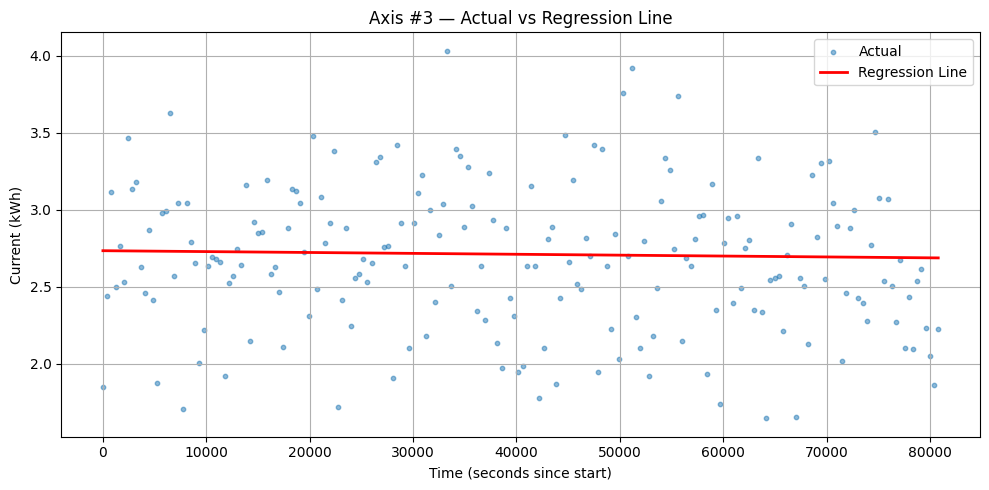

✅ Successfully saved plot to ../reports/obs_vs_pred_plots/Axis_#4_obs_vs_pred.png


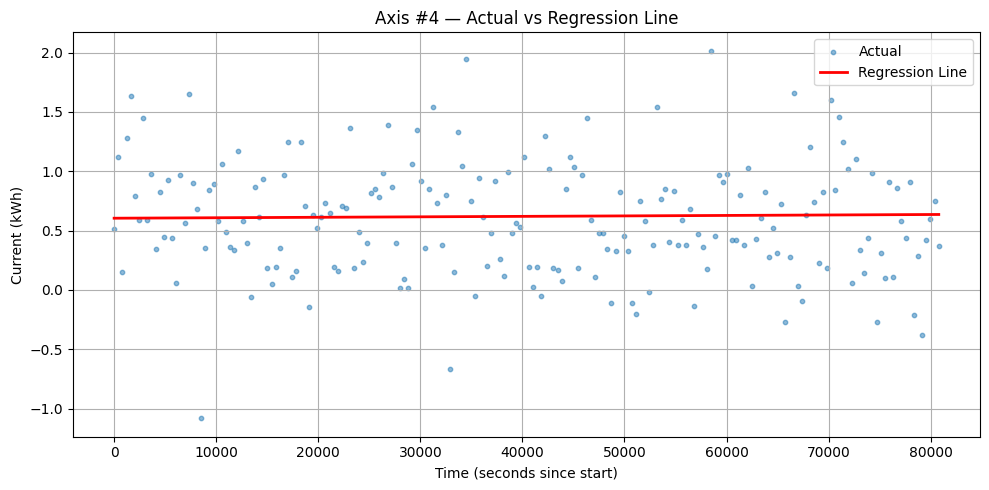

✅ Successfully saved plot to ../reports/obs_vs_pred_plots/Axis_#5_obs_vs_pred.png


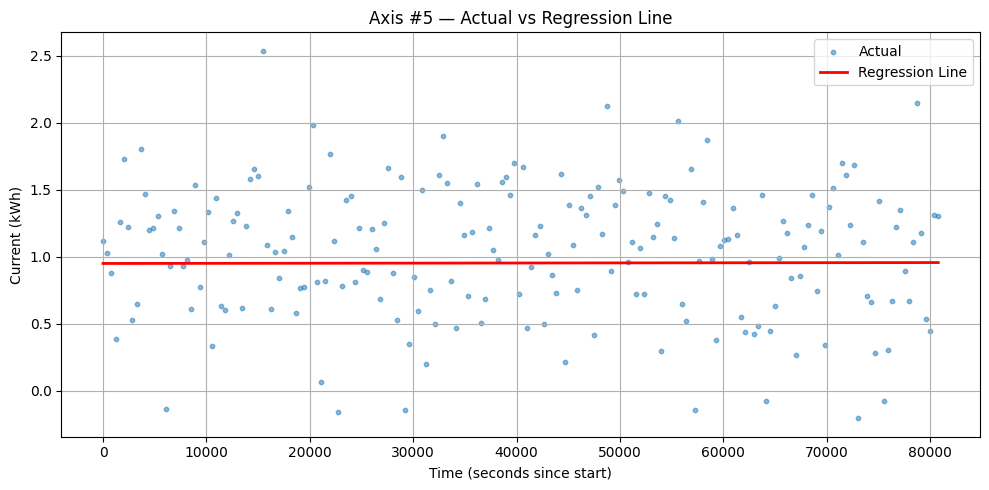

✅ Successfully saved plot to ../reports/obs_vs_pred_plots/Axis_#6_obs_vs_pred.png


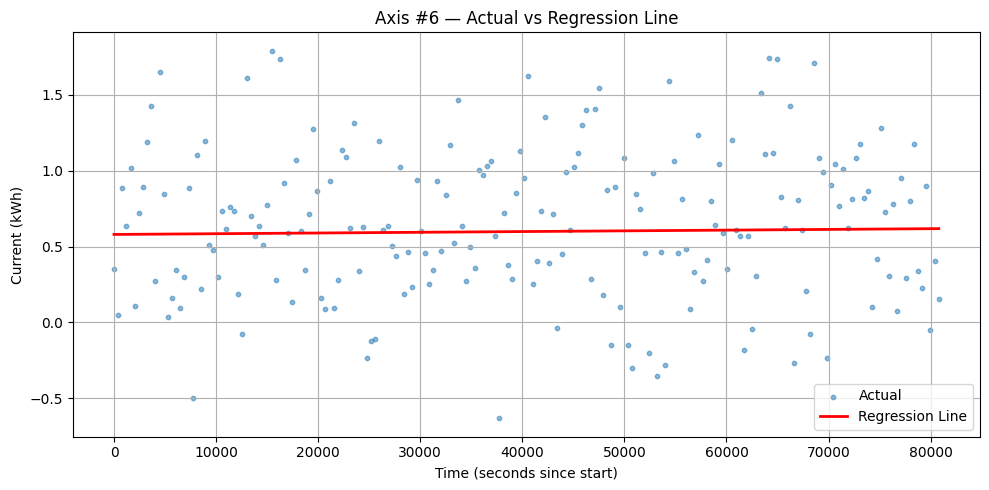

✅ Successfully saved plot to ../reports/obs_vs_pred_plots/Axis_#7_obs_vs_pred.png


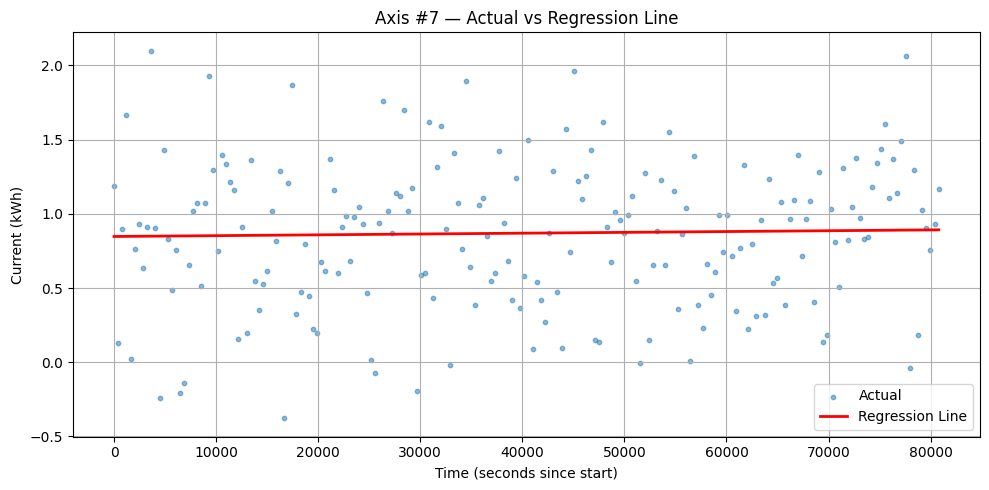

✅ Successfully saved plot to ../reports/obs_vs_pred_plots/Axis_#8_obs_vs_pred.png


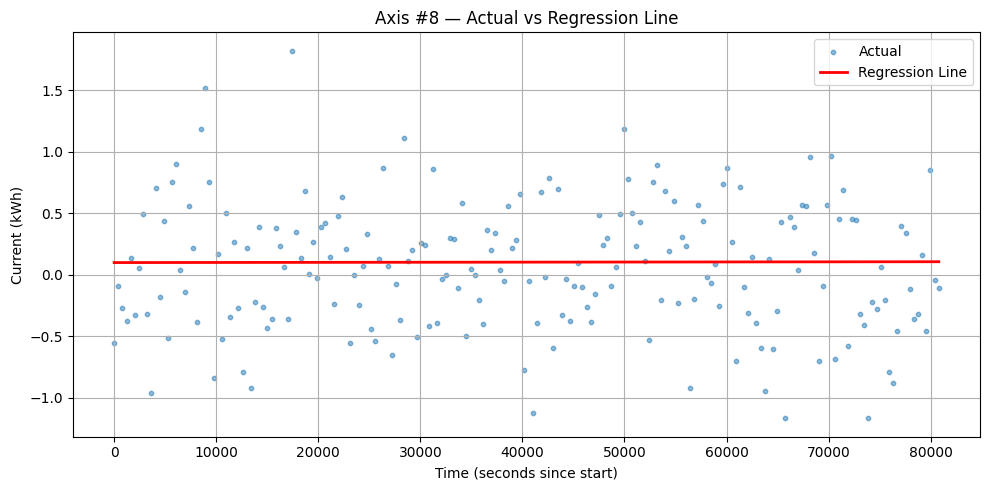

In [128]:

for axis in axis_columns:
    plt.figure(figsize=(10, 5))
    
    # Scatter: actual values
    plt.scatter(df_pred['time_numeric'], df_pred[axis], alpha=0.5, label="Actual", s=10)
    
    # Line: predicted regression line
    plt.plot(df_pred['time_numeric'], df_pred[f'{axis}_pred'], color="red", linewidth=2, label="Regression Line")
    
    plt.title(f"{axis} — Actual vs Regression Line")
    plt.xlabel("Time (seconds since start)")
    plt.ylabel("Current (kWh)")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    fileManager.write_plot(os.path.join('../reports/obs_vs_pred_plots/', f"{axis.replace(' ', '_')}_obs_vs_pred.png"), plt)
    plt.show()

## Step 8: Residual Analysis

We will:
1. Compute residuals = actual value – predicted value.
2. Plot residuals over time (to check patterns).
3. Visualize distribution of residuals (scatter, line, and boxplots).
4. Identify outliers or systematic deviations.


✅ Successfully saved plot to ../reports/residuals_plots/Axis_#1_residual_plot.png


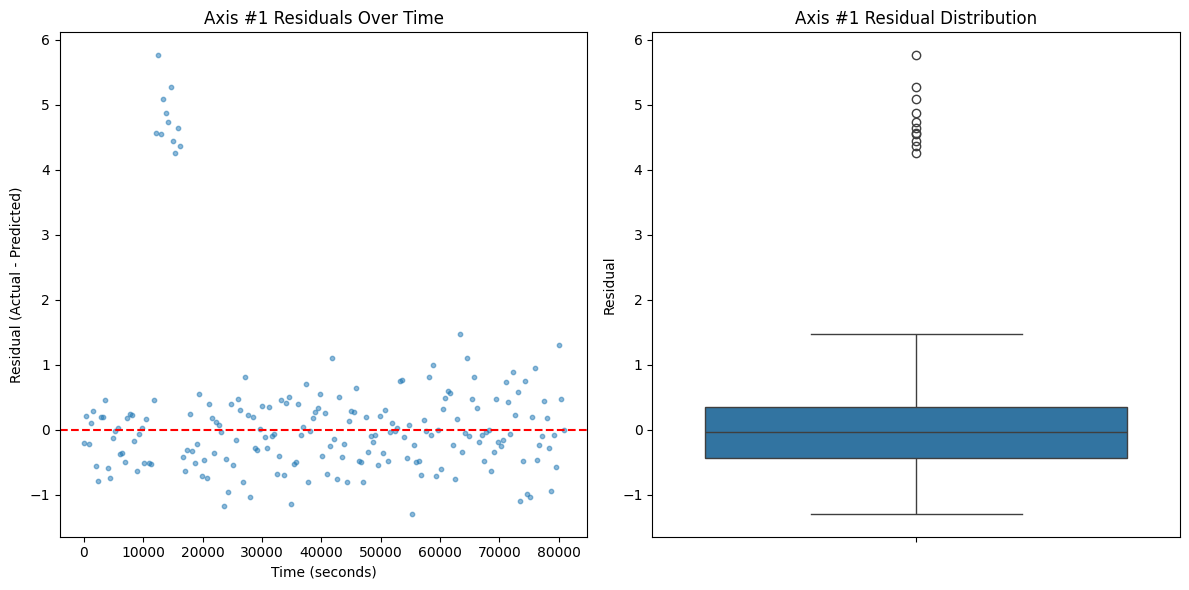

✅ Successfully saved plot to ../reports/residuals_plots/Axis_#2_residual_plot.png


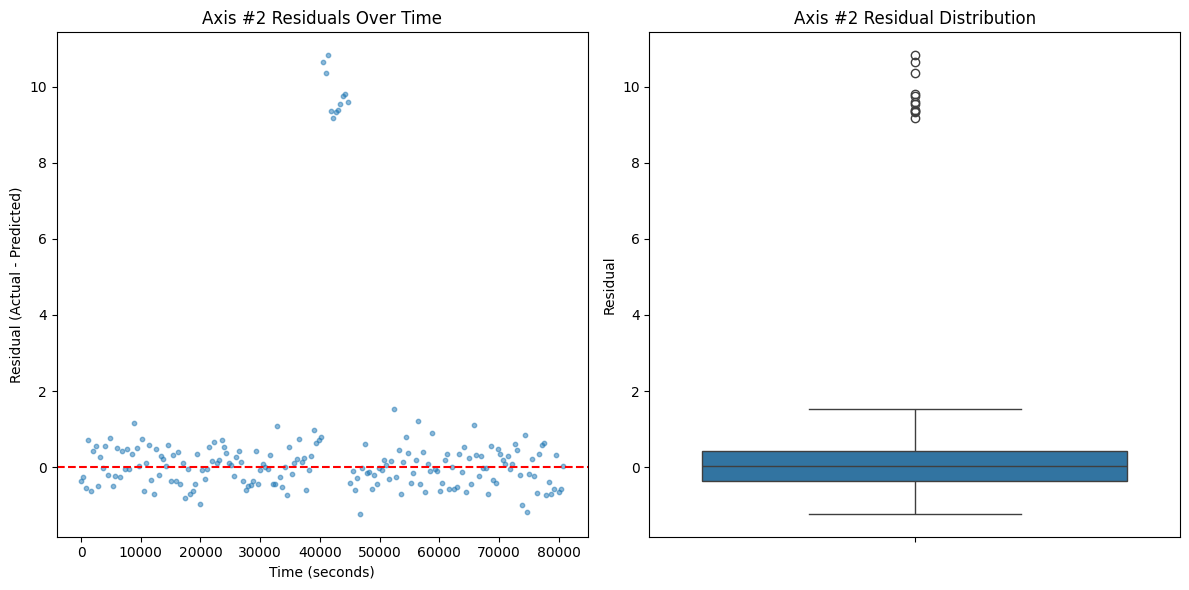

✅ Successfully saved plot to ../reports/residuals_plots/Axis_#3_residual_plot.png


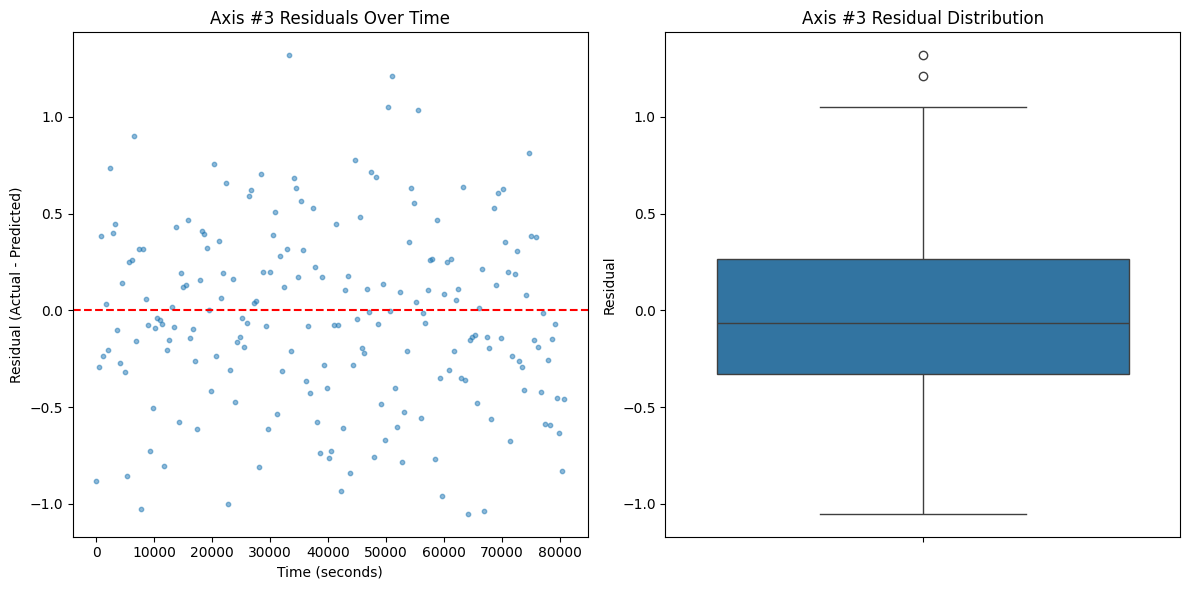

✅ Successfully saved plot to ../reports/residuals_plots/Axis_#4_residual_plot.png


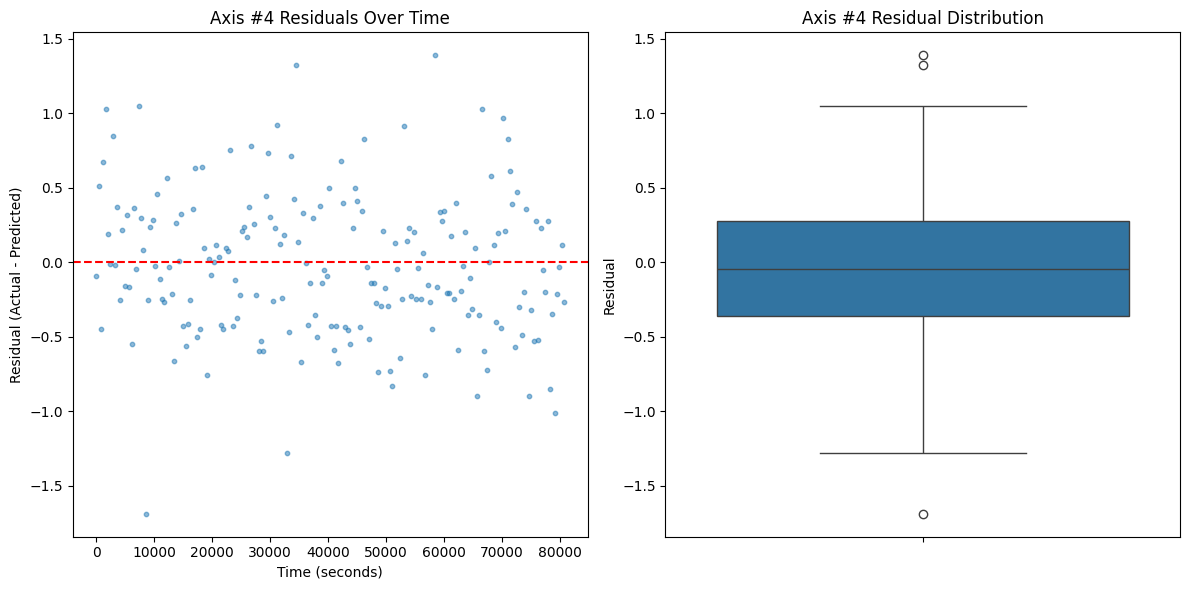

✅ Successfully saved plot to ../reports/residuals_plots/Axis_#5_residual_plot.png


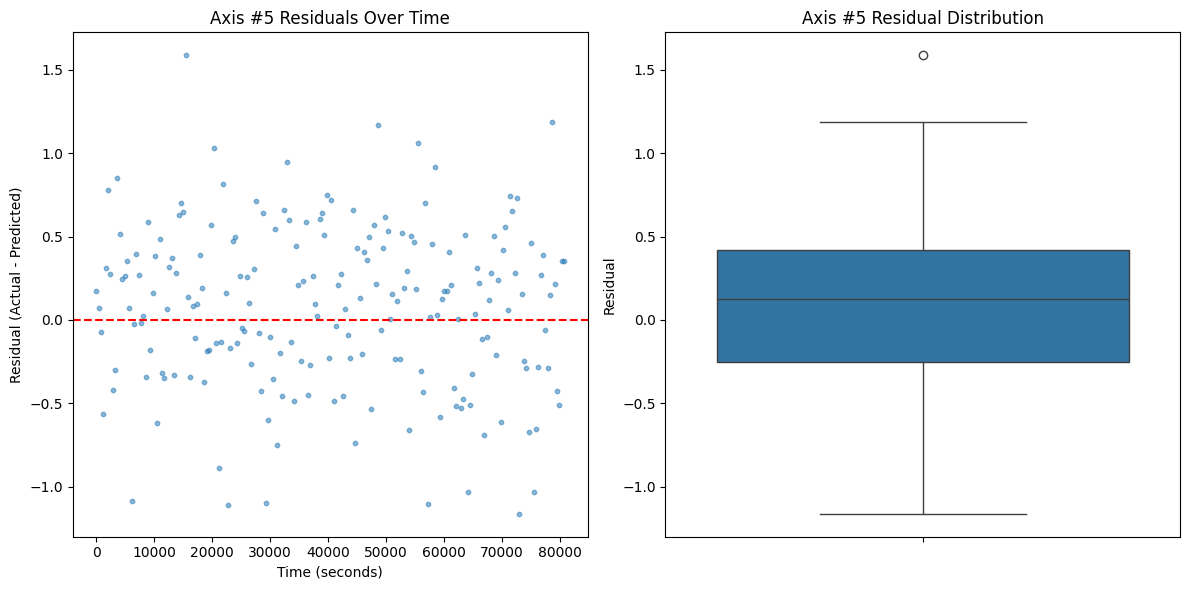

✅ Successfully saved plot to ../reports/residuals_plots/Axis_#6_residual_plot.png


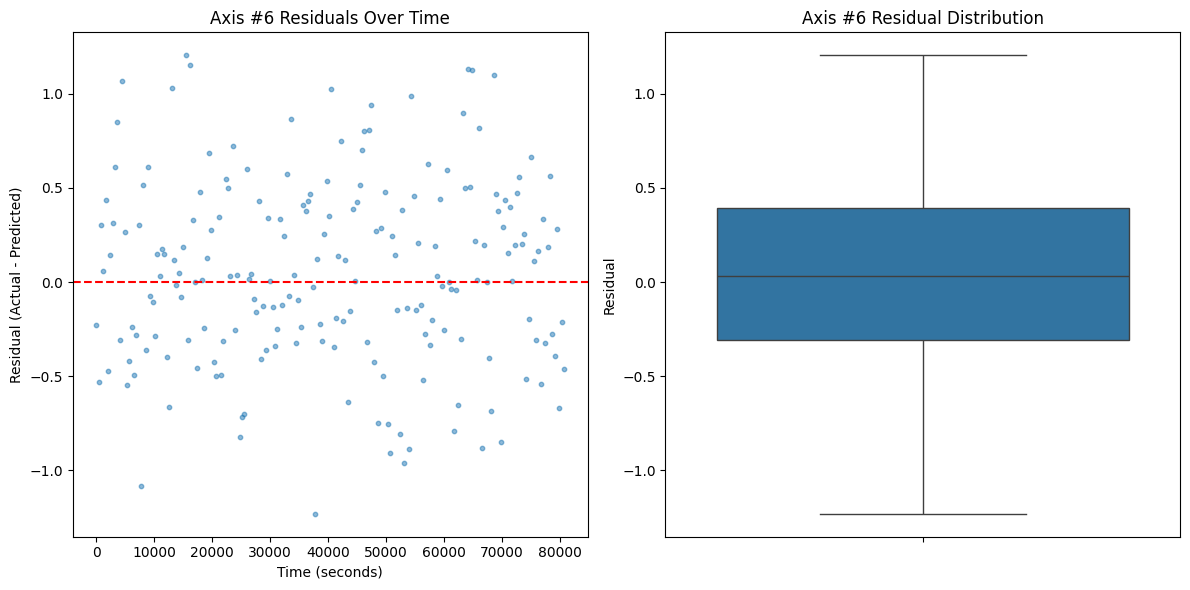

✅ Successfully saved plot to ../reports/residuals_plots/Axis_#7_residual_plot.png


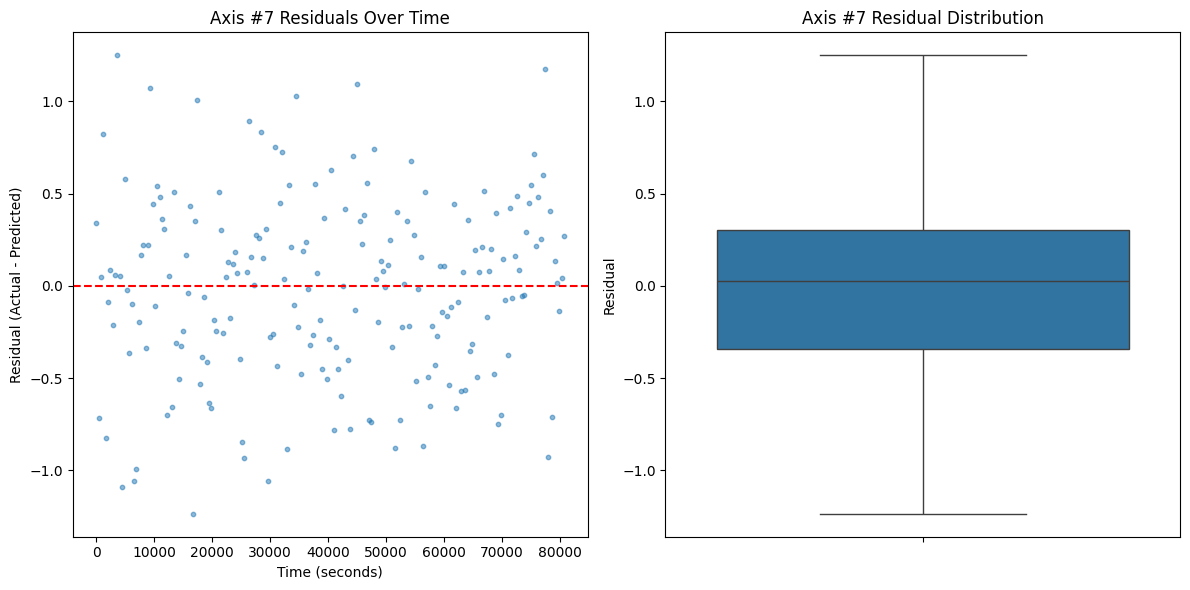

✅ Successfully saved plot to ../reports/residuals_plots/Axis_#8_residual_plot.png


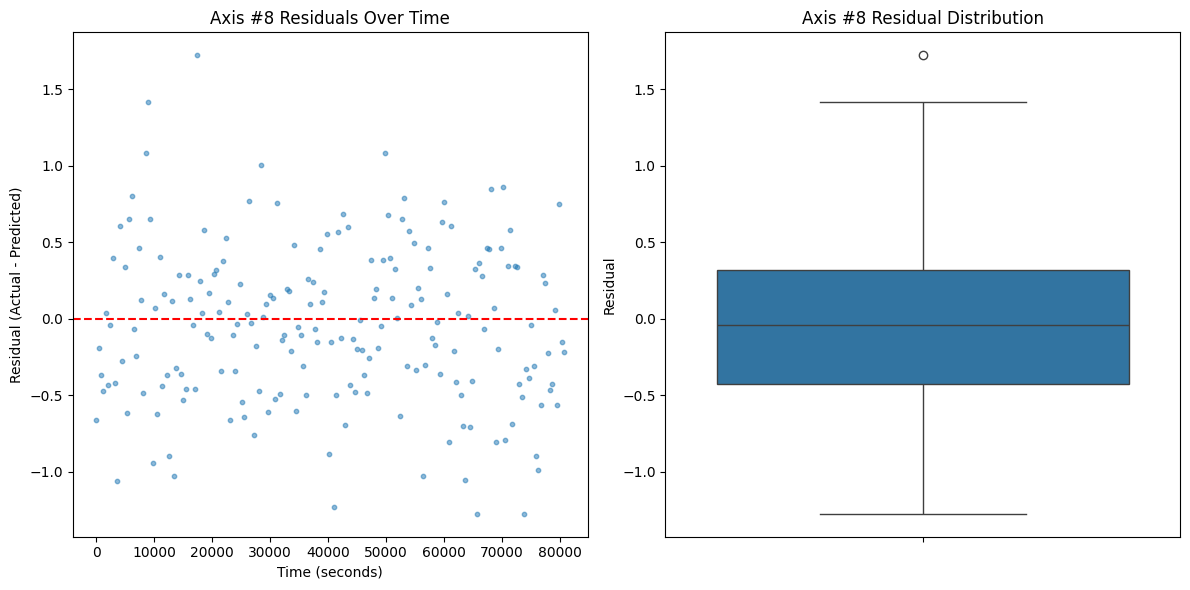

,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
mean,0.198038,0.549127,-0.038101,-0.032145,0.078302,0.049802,-0.020957,-0.044755
std,1.217988,2.292334,0.468123,0.478505,0.486665,0.491725,0.487277,0.515579
min,-1.293551,-1.224508,-1.051170,-1.689585,-1.161954,-1.231112,-1.234843,-1.272997
max,5.761131,10.825038,1.317573,1.388529,1.586423,1.204742,1.249883,1.721308
outlier_count,11.000000,11.000000,2.000000,3.000000,1.000000,0.000000,0.000000,1.000000


In [129]:
residual_summary = {}
df_residuals = df_pred.copy()

# Compute residuals for each axis
for axis in axis_columns:
    df_residuals[f'{axis}_resid'] = df_residuals[axis] - df_residuals[f'{axis}_pred']

# Plot residuals for each axis
for axis in axis_columns:
    resid_col = f'{axis}_resid'
    resid = df_residuals[resid_col].dropna()

    # Basic stats
    mean_resid = resid.mean()
    std_resid = resid.std()
    min_resid = resid.min()
    max_resid = resid.max()

    # Outlier detection (IQR method)
    Q1 = resid.quantile(0.25)
    Q3 = resid.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((resid < lower_bound) | (resid > upper_bound)).sum()

    residual_summary[axis] = {
        "mean": mean_resid,
        "std": std_resid,
        "min": min_resid,
        "max": max_resid,
        "outlier_count": outlier_count,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound
    }
    
    plt.figure(figsize=(12, 6))
    
    # Subplot 1: residuals over time
    plt.subplot(1, 2, 1)
    plt.scatter(df_residuals['time_numeric'], df_residuals[resid_col], alpha=0.5, s=10)
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"{axis} Residuals Over Time")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Residual (Actual - Predicted)")
    # Subplot 2: distribution (boxplot)
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df_residuals[resid_col])
    plt.title(f"{axis} Residual Distribution")
    plt.ylabel("Residual")
    plt.tight_layout()
    fileManager.write_plot(os.path.join('../reports/residuals_plots/', f"{axis.replace(' ', '_')}_residual_plot.png"), plt)
    plt.show()

residual_summary_df = pd.DataFrame(residual_summary)
residual_summary_df.head()

## Step 9 (Per-Axis): Data-Driven Thresholds

We will:
1. Compute residuals per axis.
2. For each axis:
   - **MinC** = mean residual + 2 × std residual
   - **MaxC** = mean residual + 3 × std residual
   - **T** = sampling interval × 5 (continuous samples)

In [130]:
per_axis_thresholds = {}

# Estimate sampling interval (median in seconds)
sampling_interval = df_train['time'].diff().dt.total_seconds().median()
T = sampling_interval * 5  # require ~5 consecutive samples

for axis in axis_columns:
    resid = df_residuals[f"{axis}_resid"].dropna()
    
    mean_resid = resid.mean()
    std_resid = resid.std()
    # Use mean + multiples of std (data-driven). Using mean + 2*sigma and +3*sigma as before
    MinC = mean_resid + 2 * std_resid
    MaxC = mean_resid + 3 * std_resid
    
    per_axis_thresholds[axis] = {
        "MinC": MinC,
        "MaxC": MaxC,
        "T_seconds": T
    }

per_axis_thresholds_df = pd.DataFrame(per_axis_thresholds)
per_axis_thresholds_df.head()

,Axis #1,Axis #2,Axis #3,Axis #4,Axis #5,Axis #6,Axis #7,Axis #8
MinC,2.634013,5.133794,0.898145,0.924865,1.051632,1.033252,0.953597,0.986403
MaxC,3.852001,7.426128,1.366268,1.403370,1.538297,1.524977,1.440874,1.501981
T_seconds,9.455000,9.455000,9.455000,9.455000,9.455000,9.455000,9.455000,9.455000


## Step 10: Implement Alert and Error Rules

Rules per axis:
1. **Alert:** residual ≥ MinC for ≥ T seconds continuously
2. **Error:** residual ≥ MaxC for ≥ T seconds continuously

We will:
- Iterate through each axis residuals.
- Track continuous runs above threshold.
- Record events with start time, end time, duration, and type (Alert/Error).

In [131]:
alert_error_events = []

for axis in axis_columns:
    resid = df_residuals[f"{axis}_resid"].values
    times = df_residuals["time"].values
    
    MinC = per_axis_thresholds[axis]["MinC"]
    MaxC = per_axis_thresholds[axis]["MaxC"]
    T = per_axis_thresholds[axis]["T_seconds"]
    
    sampling_interval = df_train['time'].diff().dt.total_seconds().median()
    min_points = int(np.ceil(T / sampling_interval))  # required consecutive samples
    
    current_event = None  # track ongoing event
    
    for i in range(len(resid)):
        value = resid[i]
        timestamp = times[i]
        
        # Determine if value exceeds thresholds
        if value >= MaxC:
            level = "Error"
        elif value >= MinC:
            level = "Alert"
        else:
            level = None
        
        if level:
            # Start new event
            if current_event is None:
                current_event = {
                    "axis": axis,
                    "type": level,
                    "start_time": timestamp,
                    "end_index": i,
                    "count": 1
                }
            else:
                # Continue event (upgrade Alert → Error if needed)
                current_event["end_index"] = i
                current_event["count"] += 1
                if level == "Error":
                    current_event["type"] = "Error"
        else:
            # If deviation ends, check duration
            if current_event is not None:
                duration = current_event["count"] * sampling_interval
                if duration >= T:
                    current_event["end_time"] = times[current_event["end_index"]]
                    current_event["duration_sec"] = duration
                    alert_error_events.append(current_event)
                current_event = None
    
    # Handle case where event lasts until end
    if current_event is not None:
        duration = current_event["count"] * sampling_interval
        if duration >= T:
            current_event["end_time"] = times[current_event["end_index"]]
            current_event["duration_sec"] = duration
            alert_error_events.append(current_event)

# Convert to DataFrame for inspection
events_df = pd.DataFrame(alert_error_events)
print(events_df.head())


      axis   type                    start_time  end_index  count  \
0  Axis #1  Error 2022-10-17 15:41:23.805929648         40     11   
1  Axis #2  Error 2022-10-17 23:35:04.146432160        110     11   

                       end_time  duration_sec  
0 2022-10-17 16:49:03.854572864        20.801  
1 2022-10-18 00:42:44.195075376        20.801  


## Step 11: Implement alert/error rules.

For each axis, compute the residuals = (observed − predicted).

Check whether the residuals stay:

≥ MinC for ≥ T seconds → Alert

≥ MaxC for ≥ T seconds → Error

Record start time, end time, duration, axis, event type.

In [132]:
alert_error_events = []

for axis, model in models.items():
    # Predict baseline values
    time_numeric_test = (df_test['time'] - time_min).dt.total_seconds()
    preds = model.predict(time_numeric_test.values.reshape(-1, 1))
    
    # Compute residuals
    residuals = df_test[axis] - preds
    
    # Thresholds for this axis
    MinC = per_axis_thresholds[axis]['MinC']
    MaxC = per_axis_thresholds[axis]['MaxC']
    T = per_axis_thresholds[axis]['T_seconds']
    
    # Identify Alerts and Errors
    current_event = None
    start_time = None
    
    for i, r in enumerate(residuals):
        # Determine event type for this residual
        if r >= MaxC:
            event_type = "Error"
        elif r >= MinC:
            event_type = "Alert"
        else:
            event_type = None
        
        if event_type:
            if current_event is None:
                # Start a new event
                current_event = event_type
                start_time = df_test['time'].iloc[i]
                duration = 0
            elif current_event == event_type:
                # Extend current event
                duration = (df_test['time'].iloc[i] - start_time).total_seconds()
            else:
                # Different event type -> finalize previous if duration ≥ T
                if duration >= T:
                    alert_error_events.append({
                        "axis": axis,
                        "event_type": current_event,
                        "start_time": start_time,
                        "end_time": df_test['time'].iloc[i],
                        "duration_s": duration
                    })
                # Start new event
                current_event = event_type
                start_time = df_test['time'].iloc[i]
                duration = 0
        else:
            if current_event:
                # Finalize previous if duration ≥ T
                if duration >= T:
                    alert_error_events.append({
                        "axis": axis,
                        "event_type": current_event,
                        "start_time": start_time,
                        "end_time": df_test['time'].iloc[i],
                        "duration_s": duration
                    })
                current_event = None
                start_time = None
                duration = 0

# --- Store detected events in DataFrame ---
events_df = pd.DataFrame(alert_error_events)

fileManager.write_csv("../logs/detected_events.csv", events_df)

events_df.head()

✅ Successfully wrote data to ../logs/detected_events.csv


c:\Users\MOSTAFA\Desktop\Foundations of ML Frameworks\Practical Lab 1\Predictive-Maintenance-with-Linear-Regression\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\MOSTAFA\Desktop\Foundations of ML Frameworks\Practical Lab 1\Predictive-Maintenance-with-Linear-Regression\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\MOSTAFA\Desktop\Foundations of ML Frameworks\Practical Lab 1\Predictive-Maintenance-with-Linear-Regression\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\MOSTAFA\Desktop\Foundations of ML Frameworks\Practical Lab 1\Predictive-Maintenance-with-Linear-Regression\.venv\Li

,axis,event_type,start_time,end_time,duration_s
0,Axis #1,Error,2022-10-17 15:41:23.805929648+00:00,2022-10-17 16:55:49.859437185+00:00,4060.048643
1,Axis #2,Error,2022-10-17 23:35:04.146432160+00:00,2022-10-18 00:49:30.199939698+00:00,4060.048643
2,Axis #8,Alert,2022-10-17 14:40:29.762150753+00:00,2022-10-17 14:54:01.771879396+00:00,406.004864


## Step 12: Visualization of Alerts/Errors

✅ Successfully saved plot to ../reports/alerts_plots/Axis_#1_alerts.png


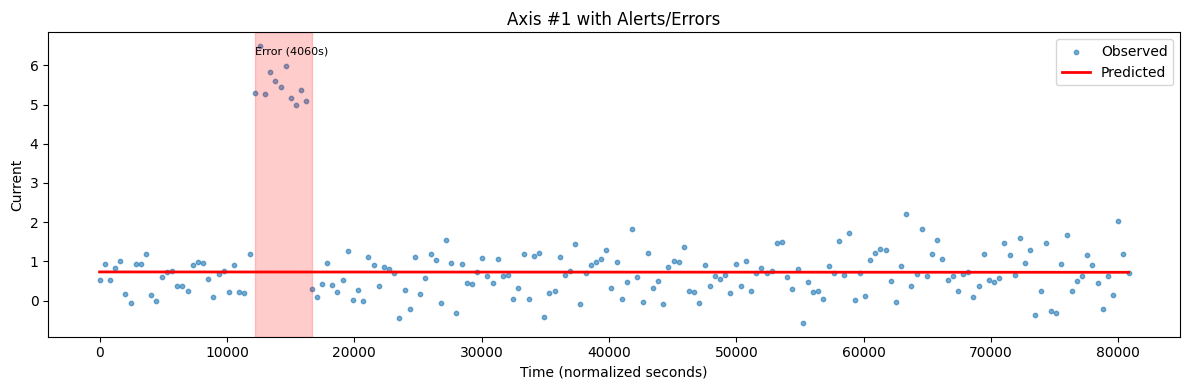

✅ Successfully saved plot to ../reports/alerts_plots/Axis_#2_alerts.png


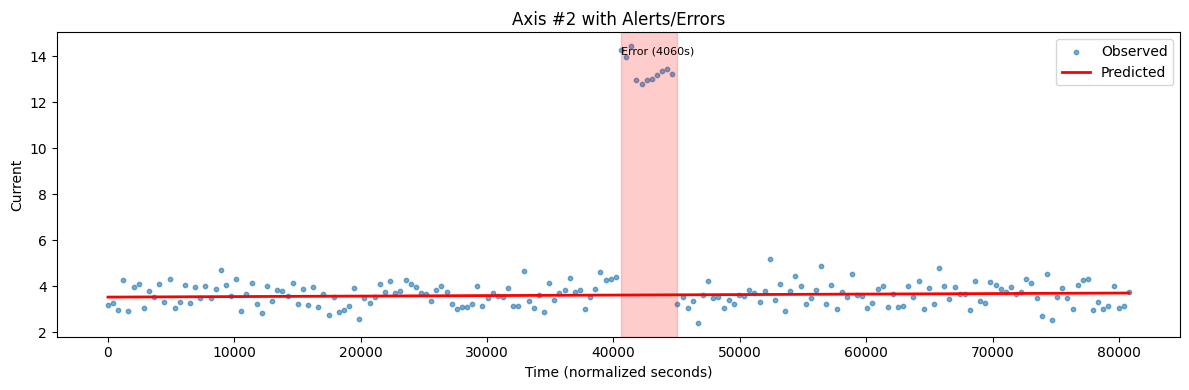

✅ Successfully saved plot to ../reports/alerts_plots/Axis_#3_alerts.png


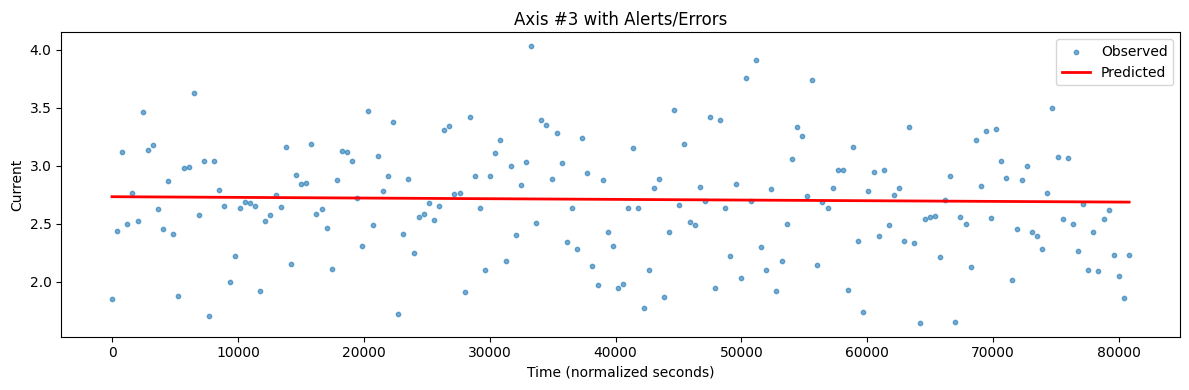

✅ Successfully saved plot to ../reports/alerts_plots/Axis_#4_alerts.png


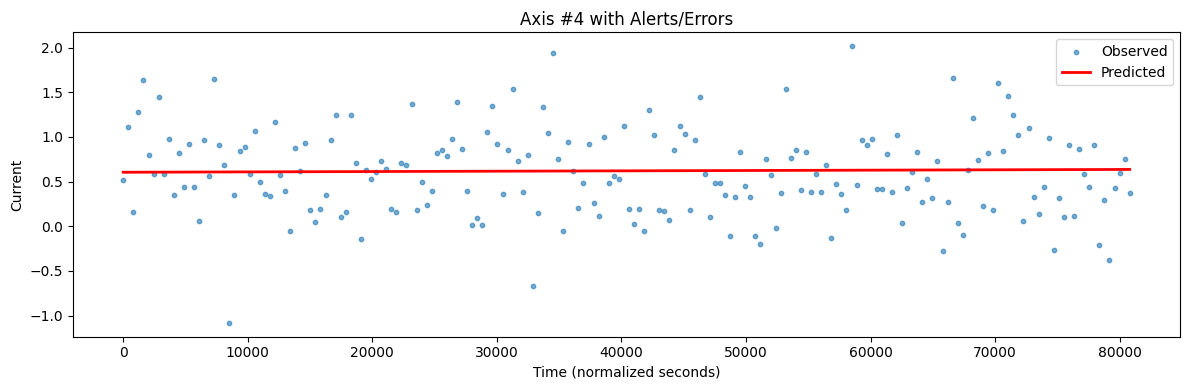

✅ Successfully saved plot to ../reports/alerts_plots/Axis_#5_alerts.png


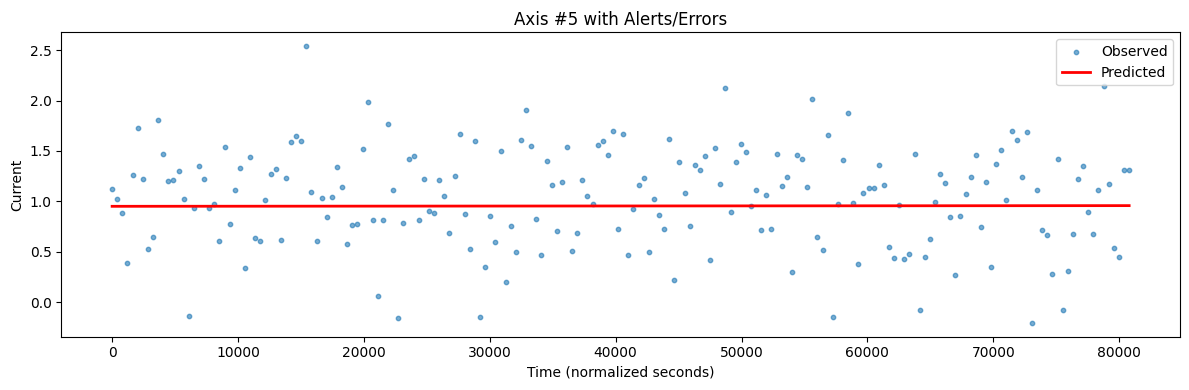

✅ Successfully saved plot to ../reports/alerts_plots/Axis_#6_alerts.png


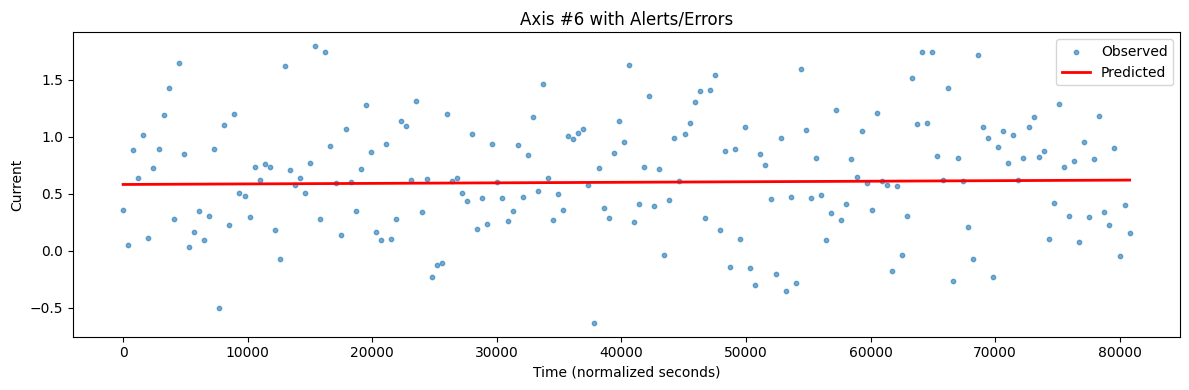

✅ Successfully saved plot to ../reports/alerts_plots/Axis_#7_alerts.png


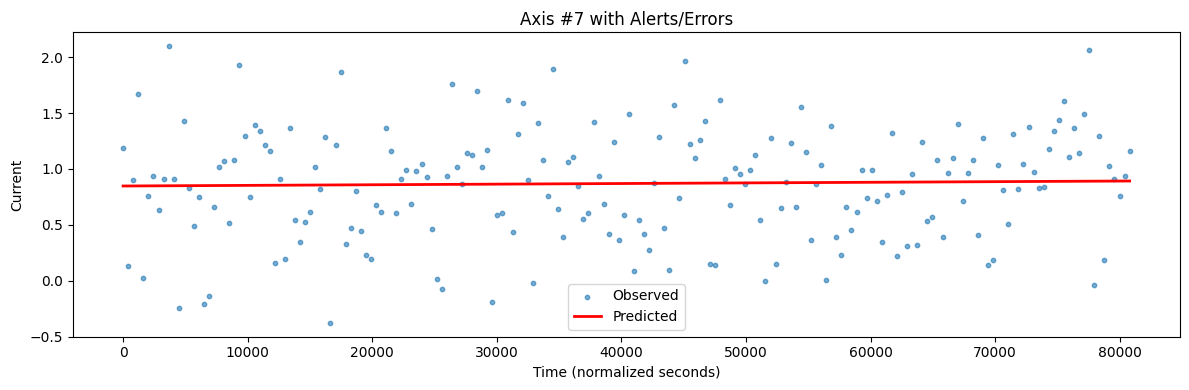

✅ Successfully saved plot to ../reports/alerts_plots/Axis_#8_alerts.png


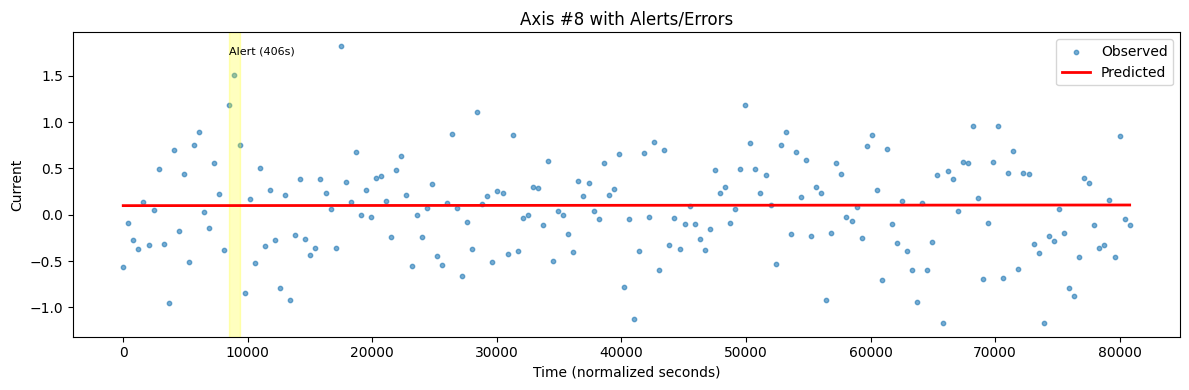

In [133]:
# Use normalized time to avoid plotting huge numbers
time_offset = df_test['time_numeric'].min()
df_test['time_norm'] = df_test['time_numeric'] - time_offset

for axis in axis_columns:
    pred_col = f"{axis}_pred"
    resid_col = f"{axis}_resid"

    plt.figure(figsize=(12, 4))
    plt.scatter(df_test['time_norm'], df_test[axis], s=10, alpha=0.6, label='Observed')
    plt.plot(df_test['time_norm'], df_pred[pred_col], color='red', linewidth=2, label='Predicted')

    # Overlay events for this axis
    axis_ev = events_df[events_df['axis'] == axis]
    for _, ev in axis_ev.iterrows():
        # convert event times back to numeric normalized coordinates
        try:
            ev_start = (pd.to_datetime(ev['start_time']) - time_min).total_seconds() - time_offset
            ev_end   = (pd.to_datetime(ev['end_time'])   - time_min).total_seconds() - time_offset
        except Exception:
            # if start_time/end_time are already strings without tz, parse gracefully
            ev_start = (pd.to_datetime(ev['start_time']) - time_min).total_seconds() - time_offset
            ev_end   = (pd.to_datetime(ev['end_time']) - time_min).total_seconds() - time_offset

        color = "yellow" if ev['event_type'] == "Alert" else "red"
        alpha = 0.25 if ev['event_type'] == "Alert" else 0.2
        plt.axvspan(ev_start, ev_end, color=color, alpha=alpha)
        plt.text(ev_start, df_test[axis].max(), f"{ev['event_type']} ({int(ev['duration_s'])}s)", 
                 fontsize=8, color='black', verticalalignment='top')

    plt.title(f"{axis} with Alerts/Errors")
    plt.xlabel("Time (normalized seconds)")
    plt.ylabel("Current")
    plt.legend()
    plt.tight_layout()
    fileManager.write_plot(os.path.join("../reports/alerts_plots/", f"{axis.replace(' ', '_')}_alerts.png"), plt)
    plt.show()
    plt.close()